# `EmissionAbsorptionModel` Tutorial

Trey V. Wenger (c) October 2024

Here we demonstrate the basic features of the `EmissionAbsorptionModel` model. `EmissionAbsorptionModel` models both 21cm emission and absorption observations simultaneously.

In [1]:
# General imports
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

print("pymc version:", pm.__version__)

import bayes_spec

print("bayes_spec version:", bayes_spec.__version__)

import caribou_hi

print("caribou_hi version:", caribou_hi.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.16.2
bayes_spec version: 1.7.0
caribou_hi version: 1.2.0b1


## Simulating Data

To test the model, we must simulate some data. We can do this with `EmissionAbsorptionModel`, but we must pack a "dummy" data structure first. The model expects the observations to be named `"emission"` and `"absorption"`.

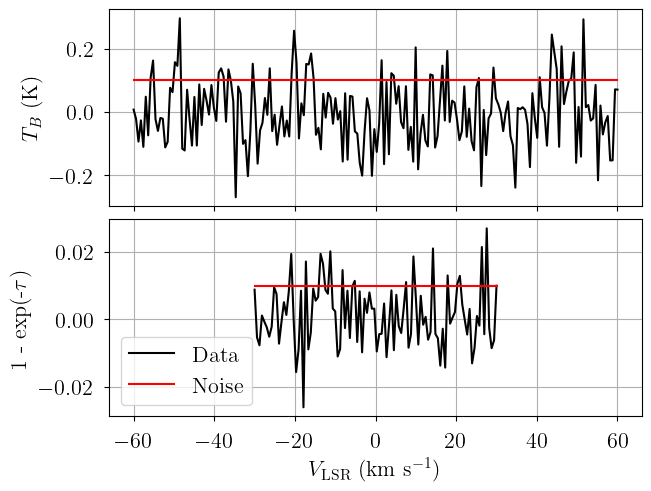

In [7]:
from bayes_spec import SpecData

# spectral axes definitions
emission_axis = np.linspace(-60.0, 60.0, 200)  # km s-1
absorption_axis = np.linspace(-30.0, 30.0, 100)  # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms_emission = 0.1  # K
rms_absorption = 0.01  # optical depth

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
emission = rms_emission * np.random.randn(len(emission_axis))
absorption = rms_absorption * np.random.randn(len(absorption_axis))

dummy_data = {
    "emission": SpecData(
        emission_axis,
        emission,
        rms_emission,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_B$ (K)",
    ),
    "absorption": SpecData(
        absorption_axis,
        absorption,
        rms_absorption,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"1 - exp(-$\tau$)",
    ),
}

# Plot dummy data
fig, axes = plt.subplots(2, layout="constrained", sharex=True)
axes[0].plot(dummy_data["emission"].spectral, dummy_data["emission"].brightness, "k-")
axes[0].plot(dummy_data["emission"].spectral, dummy_data["emission"].noise, "r-")
axes[1].plot(dummy_data["absorption"].spectral, dummy_data["absorption"].brightness, "k-", label="Data")
axes[1].plot(dummy_data["absorption"].spectral, dummy_data["absorption"].noise, "r-", label="Noise")
axes[1].set_xlabel(dummy_data["emission"].xlabel)
axes[0].set_ylabel(dummy_data["emission"].ylabel)
axes[1].set_ylabel(dummy_data["absorption"].ylabel)
_ = axes[1].legend(loc="lower left")

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood.

In [8]:
from caribou_hi import EmissionAbsorptionModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = EmissionAbsorptionModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    bg_temp=3.77,  # assumed background temperature (K)
    seed=1234,
    verbose=True,
)
model.add_priors(
    prior_log10_NHI=[20.0, 1.0],  # log10(NHI) prior mean and width (cm-2)
    prior_log10_depth=[1.0, 1.0],  # log10(depth) prior mean and width (pc)
    prior_log10_pressure=[3.0, 1.0],  # log10(pressure/k_B) prior mean and width (K cm-3)
    prior_velocity=[0.0, 5.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 1.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_log10_larson_linewidth=[0.2, 0.1],  # log10(larson_linewidth) prior mean and width (km s-1)
    prior_larson_power=[0.4, 0.1],  # mean and width of larson_power prior
    ordered=False,  # do not assume optically-thin
)
model.add_likelihood()

In [11]:
# Evaluate likelihood for given model parameters
sim_params = {
    "log10_NHI": np.array([21.0, 19.5, 20.5]),
    "log10_depth": np.array([1.5, 0.5, 2.5]),
    "log10_pressure": np.array([3.5, 3.5, 3.0]),
    "velocity": np.array([5.0, 0.0, -5.0]),
    "log10_n_alpha": -6.5,
    "log10_larson_linewidth": 0.25,
    "larson_power": 0.33,
}

sim_params_emission = sim_params.copy()
sim_params_emission["baseline_emission_norm"] = np.array([0.0])

sim_params_absorption = sim_params.copy()
sim_params_absorption["baseline_absorption_norm"] = np.array([0.0])

emission = model.model["emission"].eval(sim_params_emission)
absorption = model.model["absorption"].eval(sim_params_absorption)

data = {
    "emission": SpecData(
        emission_axis,
        emission,
        rms_emission,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_B$ (K)",
    ),
    "absorption": SpecData(
        absorption_axis,
        absorption,
        rms_absorption,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"1 - exp(-$\tau$)",
    ),
}

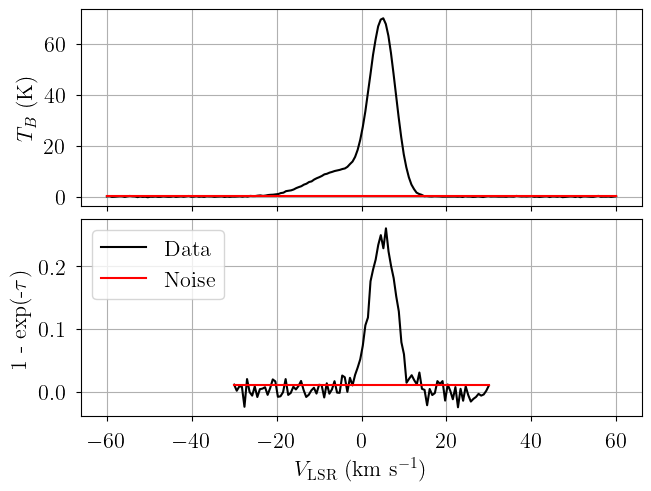

In [13]:
# Plot data
fig, axes = plt.subplots(2, layout="constrained", sharex=True)
axes[0].plot(data["emission"].spectral, data["emission"].brightness, "k-")
axes[0].plot(data["emission"].spectral, data["emission"].noise, "r-")
axes[1].plot(data["absorption"].spectral, data["absorption"].brightness, "k-", label="Data")
axes[1].plot(data["absorption"].spectral, data["absorption"].noise, "r-", label="Noise")
axes[1].set_xlabel(data["emission"].xlabel)
axes[0].set_ylabel(data["emission"].ylabel)
axes[1].set_ylabel(data["absorption"].ylabel)
_ = axes[1].legend(loc="upper left")

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `TauModel`. Here we create a new model with the simulated data.

In [14]:
# Initialize and define the model
model = EmissionAbsorptionModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    bg_temp=3.77,  # assumed background temperature (K)
    seed=1234,
    verbose=True,
)
model.add_priors(
    prior_log10_NHI=[20.0, 1.0],  # log10(NHI) prior mean and width (cm-2)
    prior_log10_depth=[1.0, 1.0],  # log10(depth) prior mean and width (pc)
    prior_log10_pressure=[3.0, 1.0],  # log10(pressure/k_B) prior mean and width (K cm-3)
    prior_velocity=[0.0, 5.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 1.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_log10_larson_linewidth=[0.2, 0.1],  # log10(larson_linewidth) prior mean and width (km s-1)
    prior_larson_power=[0.4, 0.1],  # mean and width of larson_power prior
    ordered=False,  # do not assume optically-thin
)
model.add_likelihood()

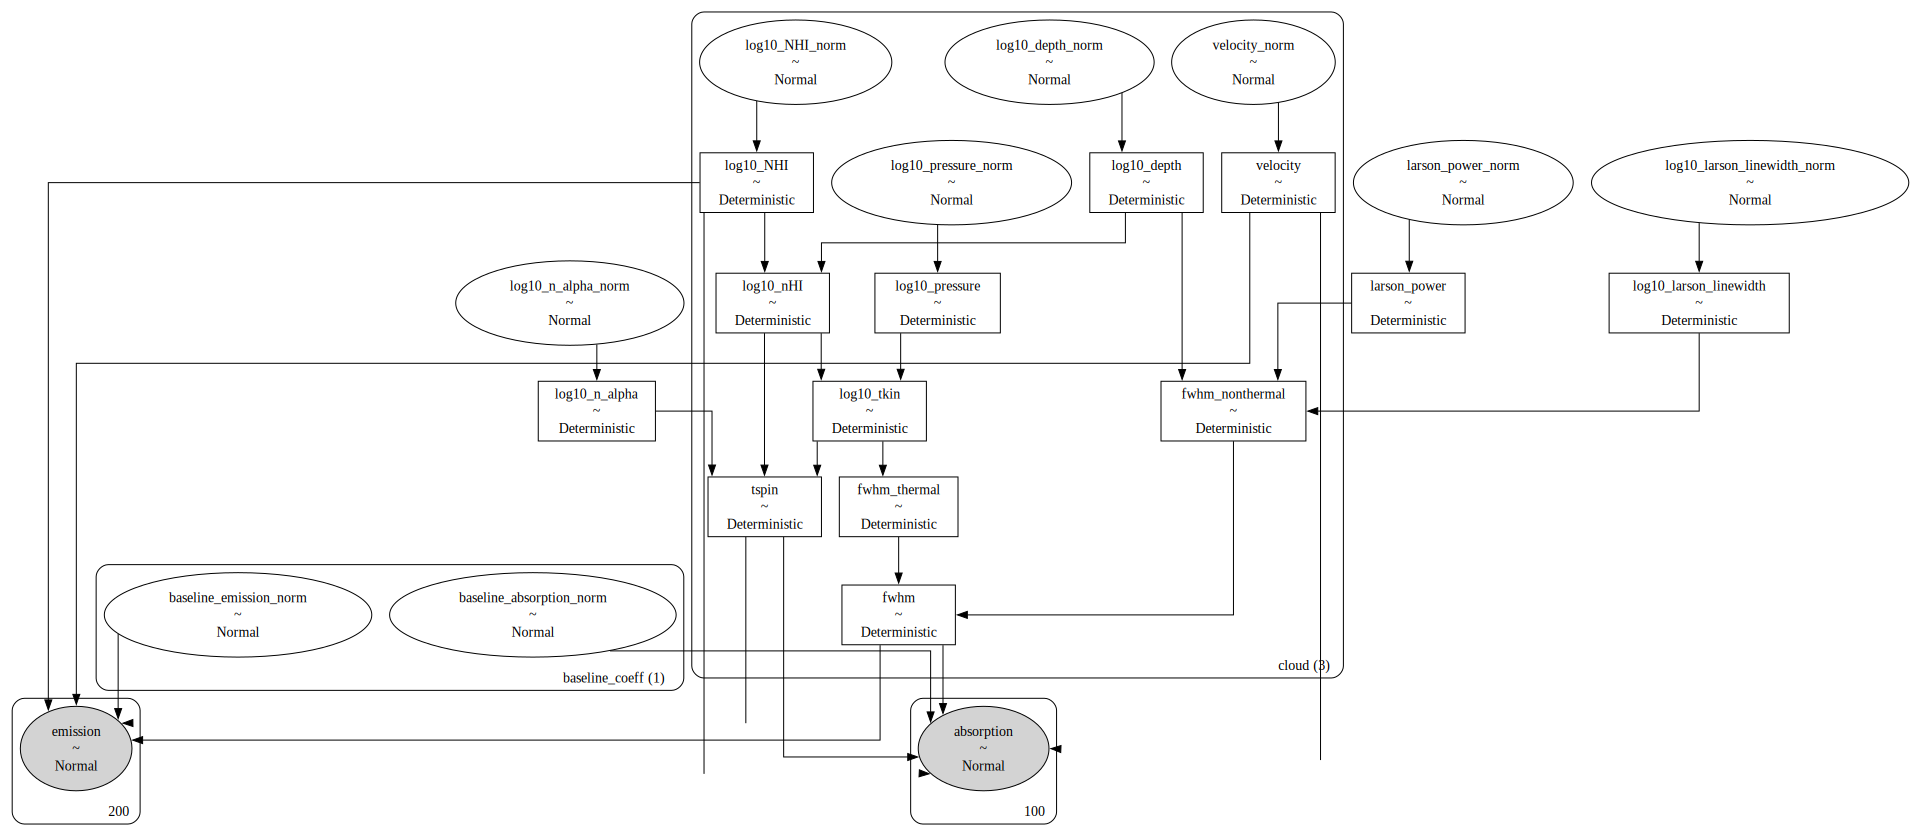

In [15]:
# Plot model graph
model.graph().render("emission_absorption_model", format="png")
model.graph()

In [16]:
# model string representation
print(model.model.str_repr())

     baseline_emission_norm ~ Normal(0, 1)
   baseline_absorption_norm ~ Normal(0, 1)
             log10_NHI_norm ~ Normal(0, 1)
           log10_depth_norm ~ Normal(0, 1)
        log10_pressure_norm ~ Normal(0, 1)
              velocity_norm ~ Normal(0, 1)
         log10_n_alpha_norm ~ Normal(0, 1)
log10_larson_linewidth_norm ~ Normal(0, 1)
          larson_power_norm ~ Normal(0, 1)
                  log10_NHI ~ Deterministic(f(log10_NHI_norm))
                log10_depth ~ Deterministic(f(log10_depth_norm))
             log10_pressure ~ Deterministic(f(log10_pressure_norm))
                   velocity ~ Deterministic(f(velocity_norm))
              log10_n_alpha ~ Deterministic(f(log10_n_alpha_norm))
     log10_larson_linewidth ~ Deterministic(f(log10_larson_linewidth_norm))
               larson_power ~ Deterministic(f(larson_power_norm))
                  log10_nHI ~ Deterministic(f(log10_depth_norm, log10_NHI_norm))
                 log10_tkin ~ Deterministic(f(log10_pressure_norm

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [absorption, baseline_absorption_norm, baseline_emission_norm, emission, larson_power_norm, log10_NHI_norm, log10_depth_norm, log10_larson_linewidth_norm, log10_n_alpha_norm, log10_pressure_norm, velocity_norm]


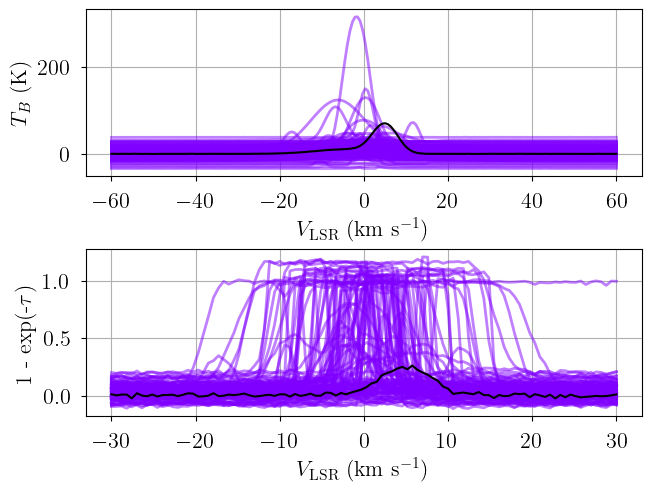

In [17]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

Or we can inspect the prior distributions of the derived quantities to check that they are physically reasonable.

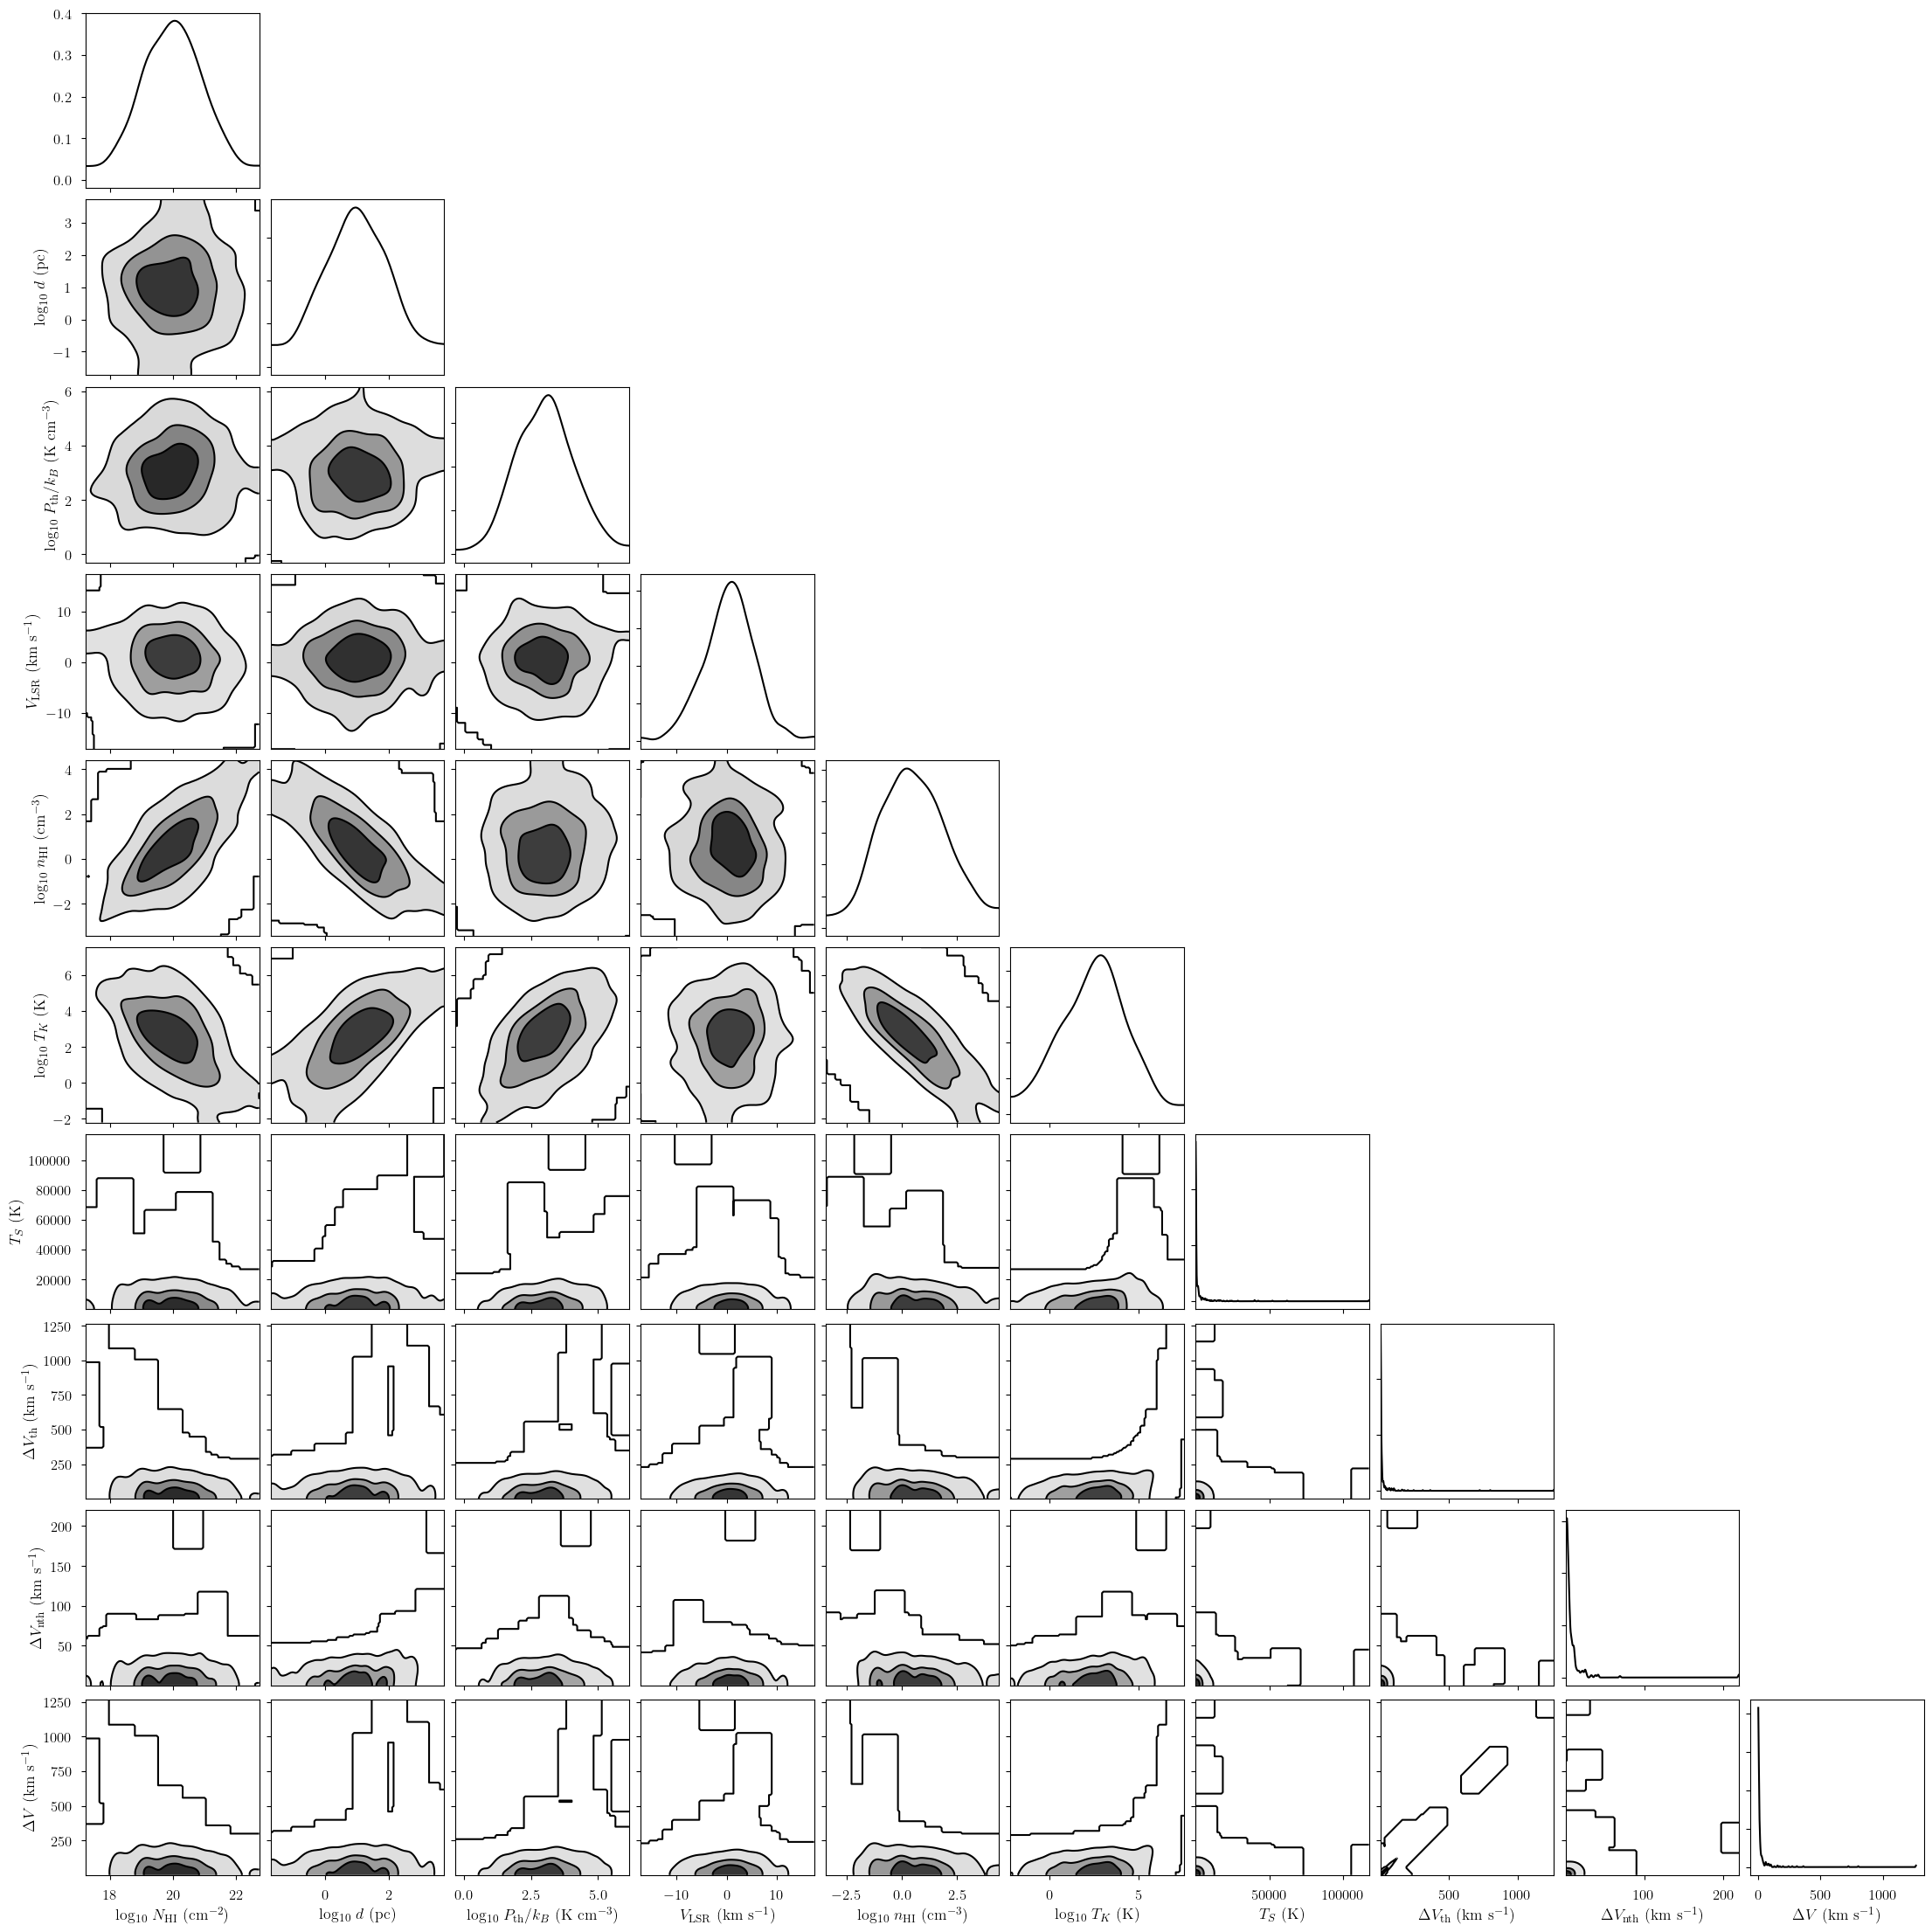

In [18]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    prior.prior,  # samples
    model.cloud_deterministics,  # var_names to plot
    labeller=model.labeller,  # label manager
)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [19]:
start = time.time()
model.fit(
    n=100_000,  # maximum number of VI iterations
    draws=1_000,  # number of posterior samples
    rel_tolerance=0.01,  # VI relative convergence threshold
    abs_tolerance=0.05,  # VI absolute convergence threshold
    learning_rate=1e-2,  # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 7800
Interrupted at 7,799 [7%]: Average Loss = 2.3492e+05


Output()

Runtime: 0.32 minutes


In [20]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean      sd    hdi_3%   hdi_97%  mcse_mean  \
baseline_absorption_norm[0]    -0.482   0.016    -0.514    -0.453      0.000   
baseline_emission_norm[0]      -0.389   0.001    -0.391    -0.388      0.000   
fwhm[0]                         7.403   0.036     7.340     7.471      0.001   
fwhm[1]                        16.787   0.078    16.642    16.929      0.003   
fwhm[2]                         6.366   0.013     6.343     6.392      0.000   
fwhm_nonthermal[0]              6.203   0.025     6.159     6.255      0.001   
fwhm_nonthermal[1]             14.756   0.055    14.649    14.852      0.002   
fwhm_nonthermal[2]              5.400   0.011     5.380     5.421      0.000   
fwhm_thermal[0]                 4.041   0.039     3.971     4.115      0.001   
fwhm_thermal[1]                 8.004   0.109     7.816     8.222      0.004   
fwhm_thermal[2]                 3.371   0.014     3.346     3.398      0.000   
larson_power                    0.436   0.000     0.435     0.436      0.000   
larson_power_norm               0.356   0.005     0.347     0.365      0.000   
log10_NHI[0]                   20.415   0.002    20.412    20.418      0.000   
log10_NHI[1]                   20.525   0.001    20.523    20.527      0.000   
log10_NHI[2]                   20.870   0.001    20.869    20.871      0.000   
log10_NHI_norm[0]               0.415   0.002     0.412     0.418      0.000   
log10_NHI_norm[1]               0.525   0.001     0.523     0.527      0.000   
log10_NHI_norm[2]               0.870   0.001     0.869     0.871      0.000   
log10_depth[0]                  1.210   0.004     1.204     1.218      0.000   
log10_depth[1]                  2.074   0.003     2.070     2.079      0.000   
log10_depth[2]                  1.072   0.001     1.070     1.074      0.000   
log10_depth_norm[0]             0.210   0.004     0.204     0.218      0.000   
log10_depth_norm[1]             1.074   0.003     1.070     1.079      0.000   
log10_depth_norm[2]             0.072   0.001     0.070     0.074      0.000   
log10_larson_linewidth          0.265   0.001     0.265     0.267      0.000   
log10_larson_linewidth_norm     0.655   0.005     0.646     0.665      0.000   
log10_nHI[0]                    0.716   0.004     0.708     0.723      0.000   
log10_nHI[1]                   -0.039   0.003    -0.044    -0.034      0.000   
log10_nHI[2]                    1.309   0.001     1.306     1.311      0.000   
log10_n_alpha                  -5.648   0.762    -7.056    -4.198      0.026   
log10_n_alpha_norm              0.352   0.762    -1.056     1.802      0.026   
log10_pressure[0]               3.310   0.008     3.296     3.323      0.000   
log10_pressure[1]               3.149   0.011     3.128     3.171      0.000   
log10_pressure[2]               3.745   0.003     3.739     3.752      0.000   
log10_pressure_norm[0]          0.310   0.008     0.296     0.323      0.000   
log10_pressure_norm[1]          0.149   0.011     0.128     0.171      0.000   
log10_pressure_norm[2]          0.745   0.003     0.739     0.752      0.000   
log10_tkin[0]                   2.553   0.008     2.537     2.568      0.000   
log10_tkin[1]                   3.146   0.012     3.126     3.169      0.000   
log10_tkin[2]                   2.395   0.004     2.389     2.402      0.000   
tspin[0]                      355.352   6.908   342.475   367.863      0.227   
tspin[1]                     1338.508  64.871  1208.379  1443.439      2.030   
tspin[2]                      247.987   2.064   244.114   251.719      0.066   
velocity[0]                     3.948   0.010     3.929     3.968      0.000   
velocity[1]                    -4.594   0.027    -4.643    -4.544      0.001   
velocity[2]                     5.259   0.003     5.254     5.264      0.000   
velocity_norm[0]                0.790   0.002     0.786     0.794      0.000   
velocity_norm[1]               -0.919   0.005    -0.929    -0.909      0.000   
velocity_norm[2]                1

Sampling: [absorption, emission]


Output()

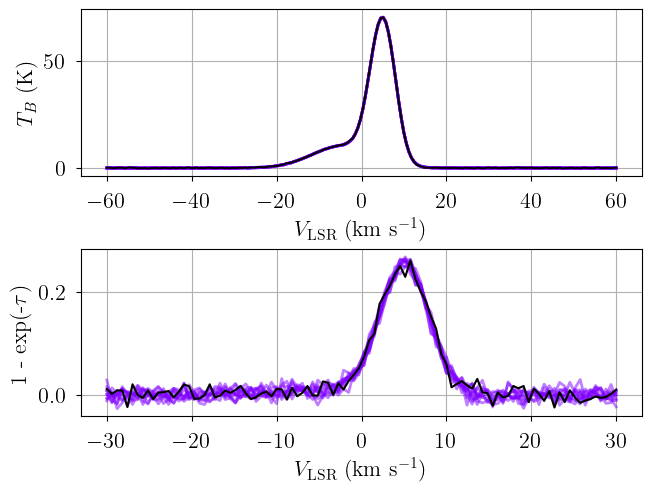

In [21]:
posterior = model.sample_posterior_predictive(
    thin=100,  # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

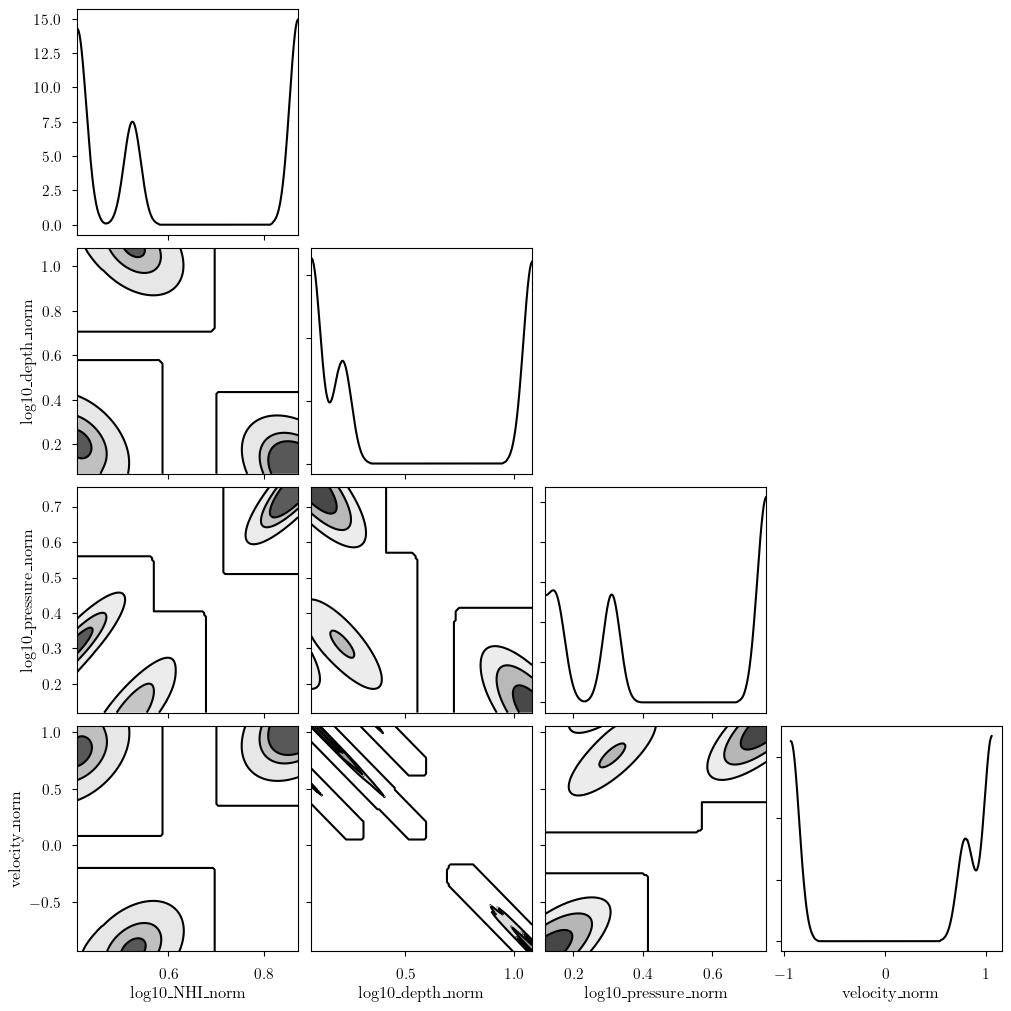

In [22]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.posterior,  # samples
    model.cloud_freeRVs,  # var_names to plot
    labeller=model.labeller,  # label manager
)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [23]:
start = time.time()
model.sample(
    init="advi+adapt_diag",  # initialization strategy
    tune=1000,  # tuning samples
    draws=1000,  # posterior samples
    chains=4,  # number of independent chains
    cores=4,  # number of parallel chains
    init_kwargs={
        "rel_tolerance": 0.01,
        "abs_tolerance": 0.05,
        "learning_rate": 1e-2,
    },  # VI initialization arguments
    nuts_kwargs={"target_accept": 0.8},  # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 7800
Interrupted at 7,799 [7%]: Average Loss = 2.3492e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, log10_NHI_norm, log10_depth_norm, log10_pressure_norm, velocity_norm, log10_n_alpha_norm, log10_larson_linewidth_norm, larson_power_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1672 seconds.


Adding log-likelihood to trace


Output()

There were 6 divergences in converged chains.
Runtime: 28.60 minutes


In [24]:
model.solve()

GMM converged to unique solution


Check that the effective sample sizes are large and the covergence statistic `r_hat` is close to 1! If not, you may have to increase the number of tuning steps (`tune=2000`) or the NUTS acceptance rate (`target_accept=0.9`).

In [25]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


mean        sd    hdi_3%   hdi_97%  \
baseline_absorption_norm[0]    -0.465     0.018    -0.498    -0.431   
baseline_emission_norm[0]      -0.388     0.001    -0.389    -0.387   
fwhm[0]                         7.624     0.762     6.157     8.932   
fwhm[1]                        16.519     0.206    16.145    16.906   
fwhm[2]                         6.545     0.034     6.482     6.608   
fwhm_nonthermal[0]              5.201     1.737     1.750     7.861   
fwhm_nonthermal[1]              9.304     3.610     3.368    15.040   
fwhm_nonthermal[2]              5.534     0.035     5.467     5.594   
fwhm_thermal[0]                 5.198     1.271     3.031     7.340   
fwhm_thermal[1]                12.890     2.679     8.053    16.481   
fwhm_thermal[2]                 3.494     0.042     3.415     3.572   
larson_power                    0.384     0.082     0.233     0.540   
larson_power_norm              -0.161     0.822    -1.666     1.404   
log10_NHI[0]                   19.768     0.168    19.452    20.056   
log10_NHI[1]                   20.504     0.012    20.481    20.526   
log10_NHI[2]                   20.979     0.013    20.956    20.999   
log10_NHI_norm[0]              -0.232     0.168    -0.548     0.056   
log10_NHI_norm[1]               0.504     0.012     0.481     0.526   
log10_NHI_norm[2]               0.979     0.013     0.956     0.999   
log10_depth[0]                  1.243     0.513     0.171     2.144   
log10_depth[1]                  1.882     0.558     0.808     2.939   
log10_depth[2]                  1.422     0.359     0.805     2.091   
log10_depth_norm[0]             0.243     0.513    -0.829     1.144   
log10_depth_norm[1]             0.882     0.558    -0.192     1.939   
log10_depth_norm[2]             0.422     0.359    -0.195     1.091   
log10_larson_linewidth          0.217     0.094     0.042     0.394   
log10_larson_linewidth_norm     0.173     0.942    -1.581     1.938   
log10_nHI[0]                    0.036     0.478    -0.833     1.015   
log10_nHI[1]                    0.133     0.557    -0.910     1.214   
log10_nHI[2]                    1.068     0.357     0.393     1.675   
log10_n_alpha                  -5.995     0.962    -7.746    -4.191   
log10_n_alpha_norm              0.005     0.962    -1.746     1.809   
log10_pressure[0]               2.822     0.619     1.800     4.146   
log10_pressure[1]               3.713     0.682     2.498     5.028   
log10_pressure[2]               3.536     0.357     2.881     4.161   
log10_pressure_norm[0]         -0.178     0.619    -1.200     1.146   
log10_pressure_norm[1]          0.713     0.682    -0.502     2.028   
log10_pressure_norm[2]          0.536     0.357    -0.119     1.161   
log10_tkin[0]                   2.745     0.213     2.374     3.110   
log10_tkin[1]                   3.539     0.199     3.160     3.778   
log10_tkin[2]                   2.426     0.010     2.406     2.445   
tspin[0]                      607.322   295.622   192.330  1138.948   
tspin[1]                     3323.939  1372.587  1184.064  5663.624   
tspin[2]                      266.000     6.172   254.352   277.862   
velocity[0]                     1.456     0.892    -0.205     3.012   
velocity[1]                    -4.931     0.206    -5.310    -4.551   
velocity[2]                     5.080     0.032     5.024     5.140   
velocity_norm[0]                0.291     0.178    -0.041     0.602   
velocity_norm[1]               -0.986     0.041    -1.062    -0.910   
velocity_norm[2]                1.016     0.006     1.005     1.028   

                             mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat  
baseline_absorption_norm[0]      0.000    0.000    2123.0    2459.0   1.00  
baseline_emission_norm[0]        0.000    0.000    2538.0    2850.0   1.00  
fwhm[0]                          0.028    0.020     749.0    1529.0   1.00  
fwhm[1]                          0.007    0.005     972.0    1544.0   1.00  
fwhm[2]                   

We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [absorption, emission]


Output()

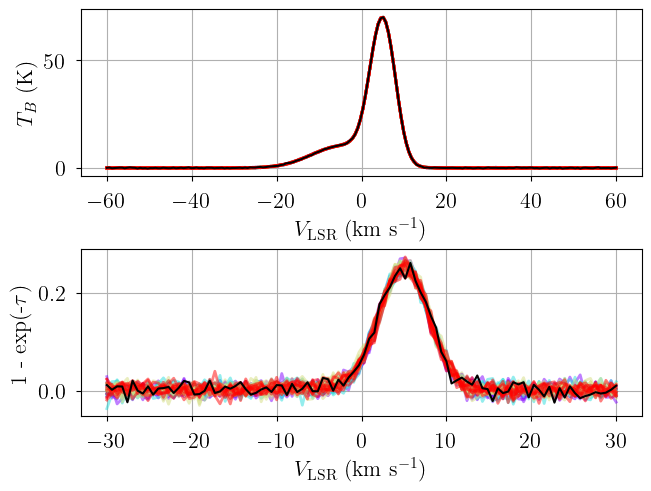

In [26]:
posterior = model.sample_posterior_predictive(
    thin=100,  # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

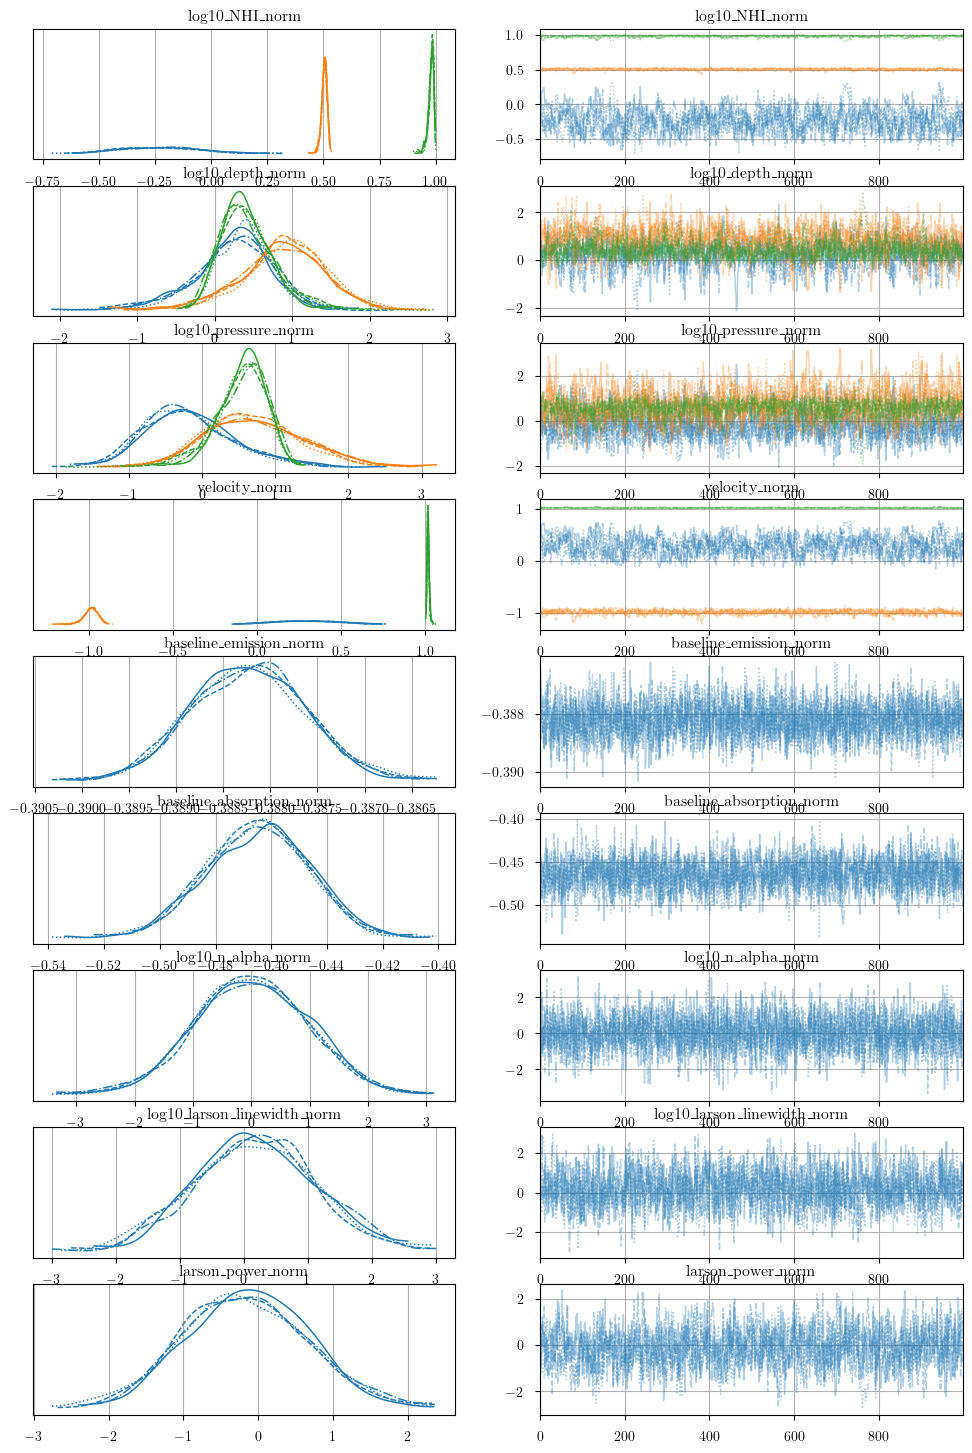

In [27]:
from bayes_spec.plots import plot_traces

_ = plot_traces(
    model.trace.solution_0,
    model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs,
)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

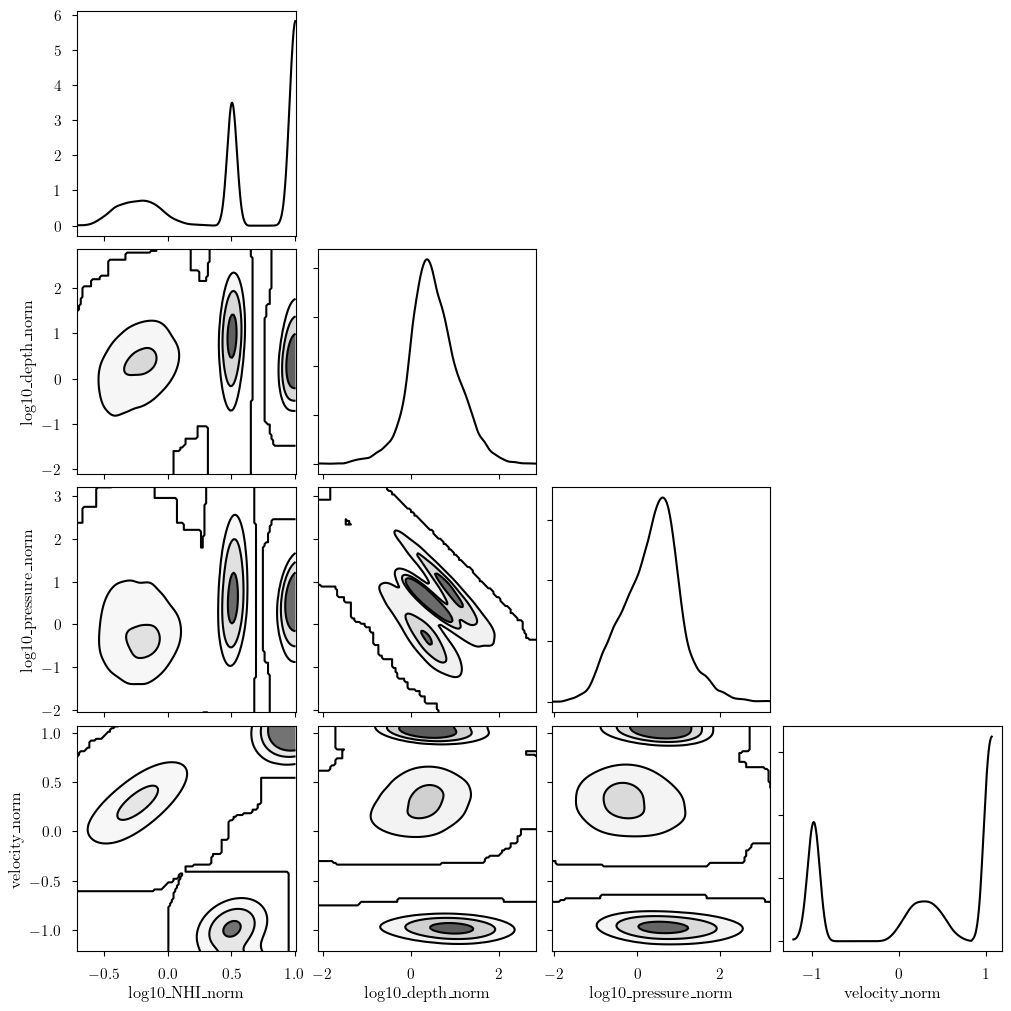

In [28]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0,  # samples
    model.cloud_freeRVs,  # var_names to plot
    labeller=model.labeller,  # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud.

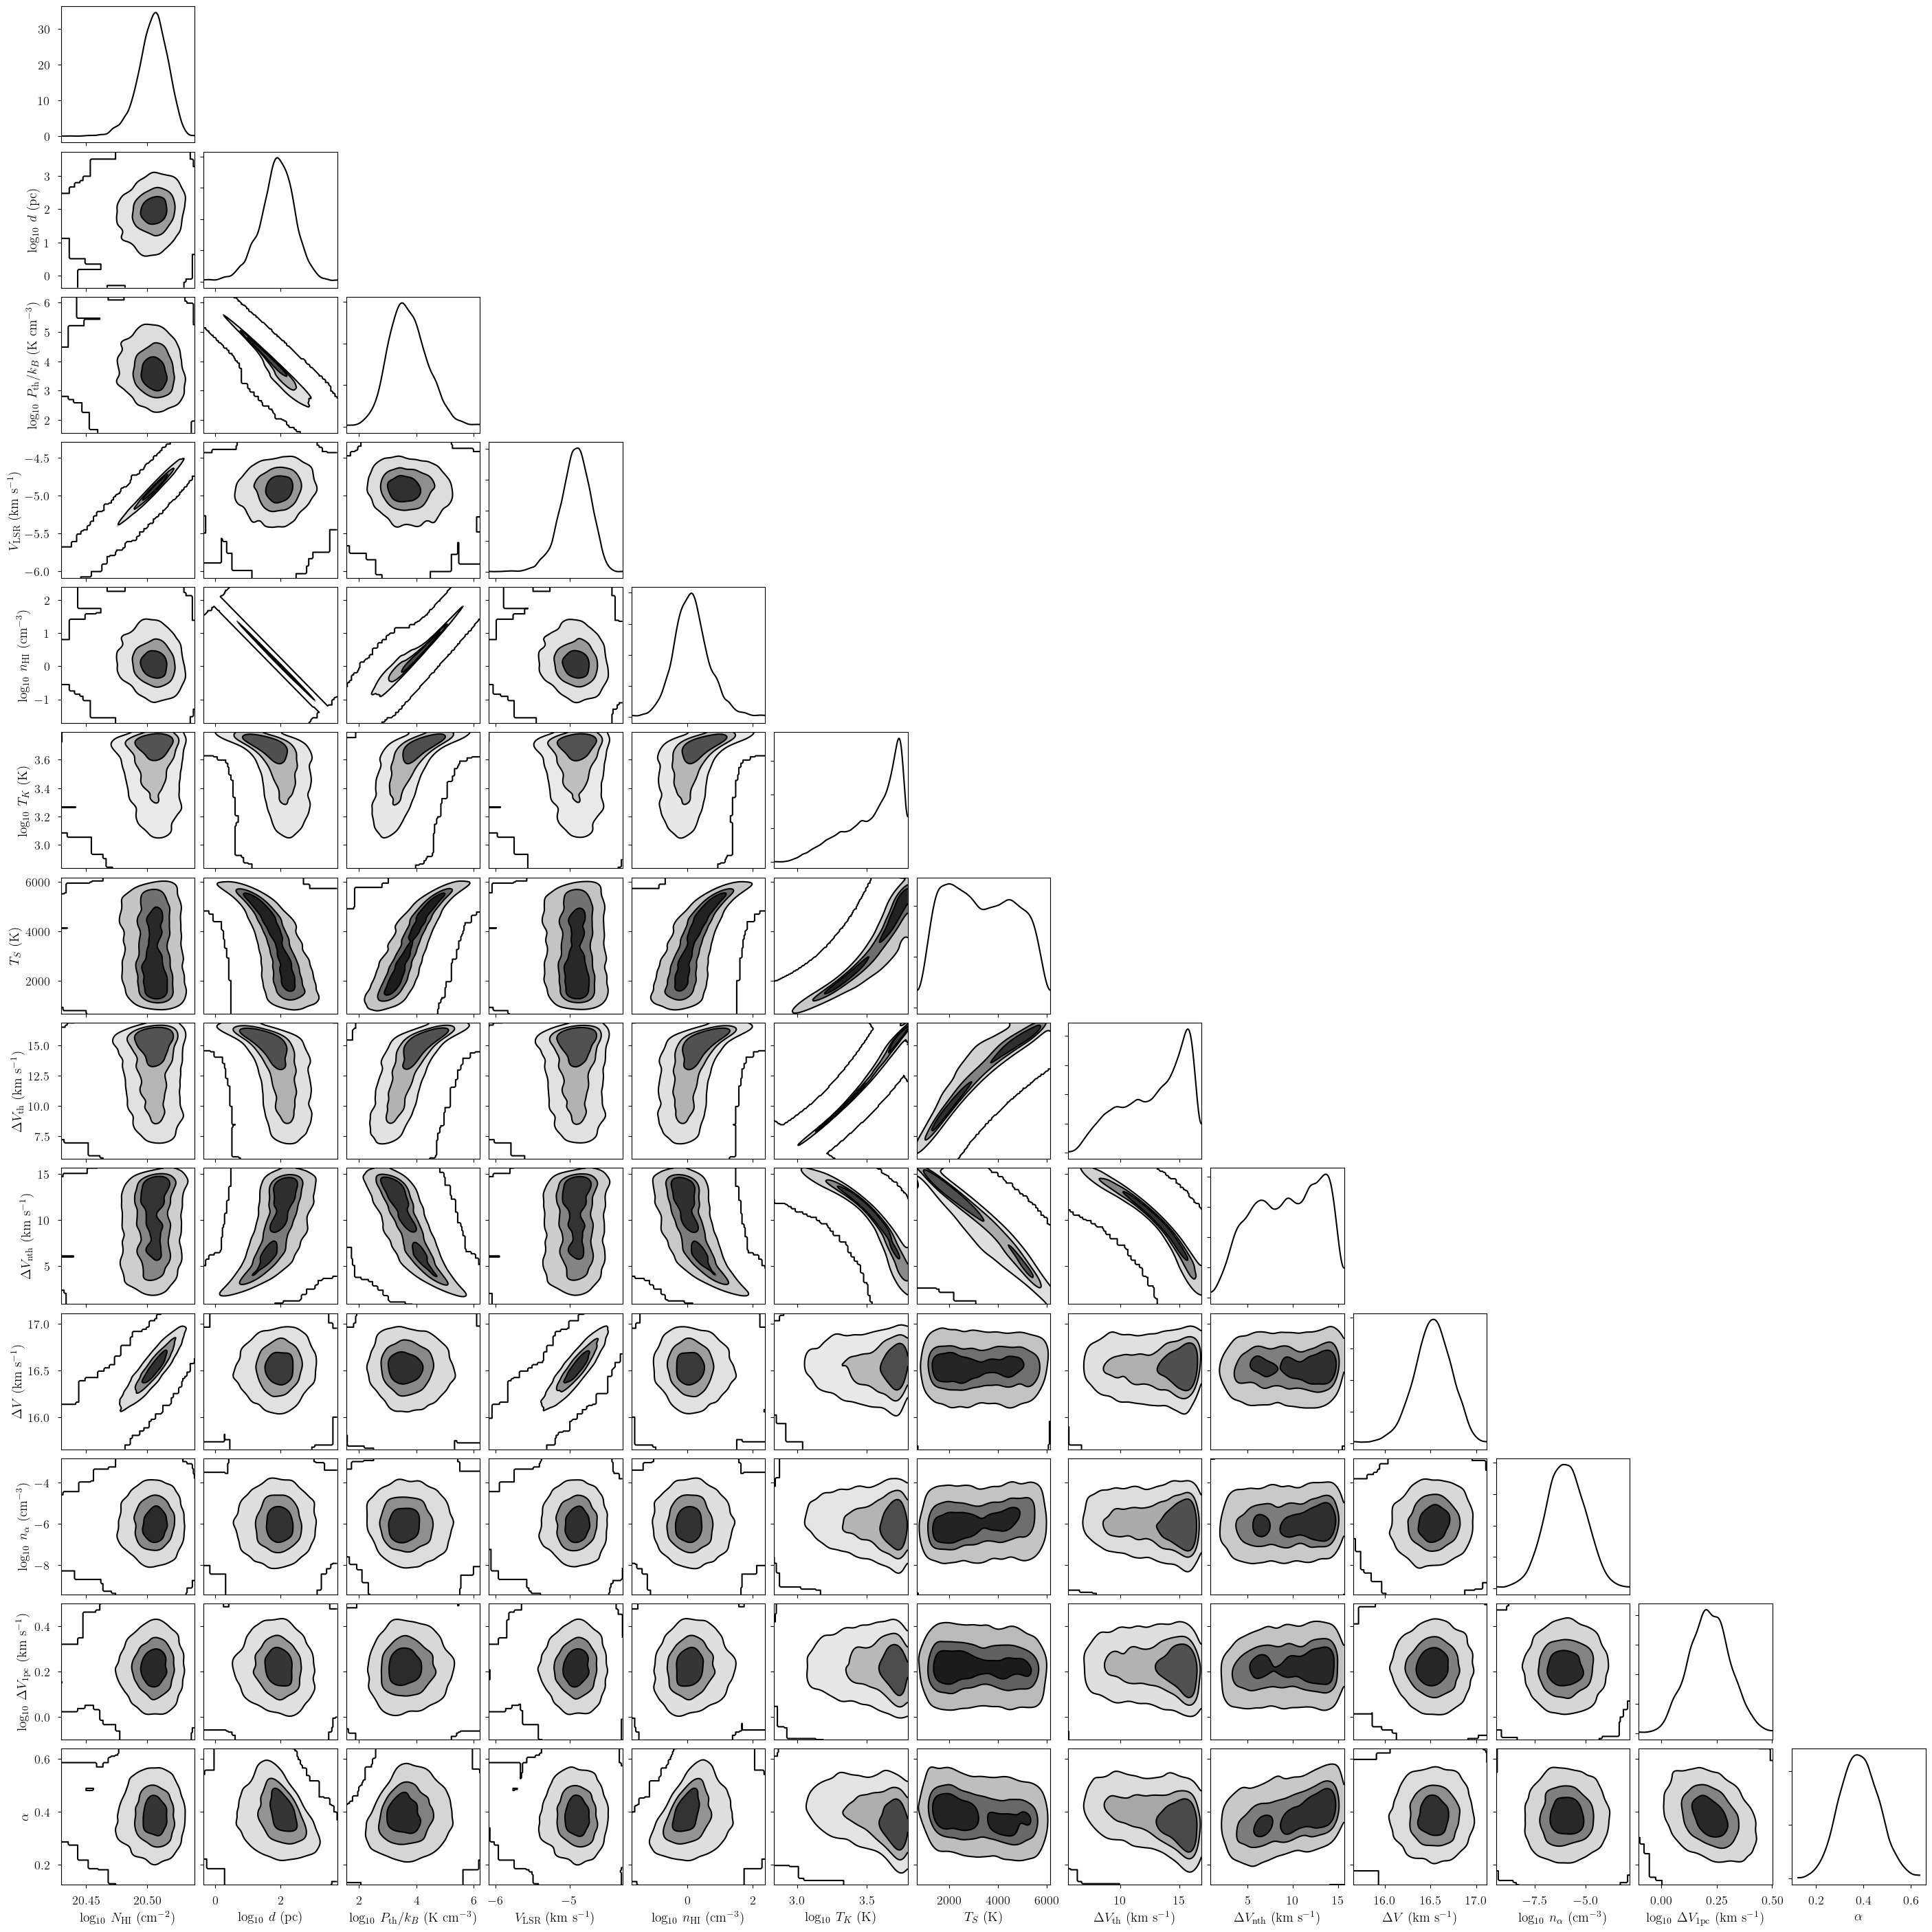

In [29]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1),  # samples
    model.cloud_deterministics + model.hyper_deterministics,  # var_names to plot
    labeller=model.labeller,  # label manager
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [30]:
point_stats = az.summary(model.trace.solution_0, kind="stats", hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -851.9955384549238


mean        sd   hdi_16%   hdi_84%
baseline_absorption_norm[0]    -0.465     0.018    -0.483    -0.447
baseline_emission_norm[0]      -0.388     0.001    -0.389    -0.388
fwhm[0]                         7.624     0.762     6.781     8.314
fwhm[1]                        16.519     0.206    16.349    16.748
fwhm[2]                         6.545     0.034     6.520     6.584
fwhm_nonthermal[0]              5.201     1.737     3.990     7.471
fwhm_nonthermal[1]              9.304     3.610     6.560    14.453
fwhm_nonthermal[2]              5.534     0.035     5.504     5.568
fwhm_thermal[0]                 5.198     1.271     3.519     6.176
fwhm_thermal[1]                12.890     2.679    11.443    16.432
fwhm_thermal[2]                 3.494     0.042     3.460     3.536
larson_power                    0.384     0.082     0.303     0.469
larson_power_norm              -0.161     0.822    -0.968     0.685
log10_NHI[0]                   19.768     0.168    19.588    19.931
log10_NHI[1]                   20.504     0.012    20.494    20.517
log10_NHI[2]                   20.979     0.013    20.974    20.994
log10_NHI_norm[0]              -0.232     0.168    -0.412    -0.069
log10_NHI_norm[1]               0.504     0.012     0.494     0.517
log10_NHI_norm[2]               0.979     0.013     0.974     0.994
log10_depth[0]                  1.243     0.513     0.870     1.782
log10_depth[1]                  1.882     0.558     1.458     2.467
log10_depth[2]                  1.422     0.359     1.006     1.646
log10_depth_norm[0]             0.243     0.513    -0.130     0.782
log10_depth_norm[1]             0.882     0.558     0.458     1.467
log10_depth_norm[2]             0.422     0.359     0.006     0.646
log10_larson_linewidth          0.217     0.094     0.122     0.308
log10_larson_linewidth_norm     0.173     0.942    -0.777     1.077
log10_nHI[0]                    0.036     0.478    -0.480     0.380
log10_nHI[1]                    0.133     0.557    -0.457     0.548
log10_nHI[2]                    1.068     0.357     0.855     1.489
log10_n_alpha                  -5.995     0.962    -6.881    -4.982
log10_n_alpha_norm              0.005     0.962    -0.881     1.018
log10_pressure[0]               2.822     0.619     2.033     3.190
log10_pressure[1]               3.713     0.682     2.964     4.277
log10_pressure[2]               3.536     0.357     3.331     3.966
log10_pressure_norm[0]         -0.178     0.619    -0.967     0.190
log10_pressure_norm[1]          0.713     0.682    -0.036     1.277
log10_pressure_norm[2]          0.536     0.357     0.331     0.966
log10_tkin[0]                   2.745     0.213     2.534     2.993
log10_tkin[1]                   3.539     0.199     3.460     3.774
log10_tkin[2]                   2.426     0.010     2.418     2.437
tspin[0]                      607.322   295.622   230.173   750.718
tspin[1]                     3323.939  1372.587  1377.494  4473.267
tspin[2]                      266.000     6.172   260.788   272.167
velocity[0]                     1.456     0.892     0.575     2.455
velocity[1]                    -4.931     0.206    -5.085    -4.698
velocity[2]                     5.080     0.032     5.047     5.103
velocity_norm[0]                0.291     0.178     0.115     0.491
velocity_norm[1]               -0.986     0.041    -1.017    -0.940
velocity_norm[2]                1.016     0.006     1.009     1.021